## Welcome to Basic hiphive tutorial
For more details see 

https://hiphive.materialsmodeling.org/




### Getting started

The easiest way to install hiphive is via `pip`

    pip3 install hiphive
    
`phonopy` is required for the last part of the tutorial, see https://atztogo.github.io/phonopy/install.html



Visualization will be done with [matplotlib](https://matplotlib.org/)

In [1]:
# Setup plotting, seaborn is just used to make figures look a bit nicer not required
%matplotlib inline
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    sns.set_context('talk')
except ModuleNotFoundError:
    print('Dont worry')

## Creating a force constant potential
In this basic tutorial we will create a force constant potential for FCC Ni and do some basic calculations of thermal properties. 

### Structure generation
The first step to constructing a FCP is to generate training structures.
This can be done in multiple ways and there is in general no correct way, a few different methods are listed at https://hiphive.materialsmodeling.org/advanced_topics/structure_generation.html.

The forces of the training structures are needed to train the FCP, these are often calculated using DFT. Here, however we will use the EMT calculator from ASE.

Lets start by generating a few structures.

In [2]:
from ase.build import bulk
from hiphive.structure_generation import generate_rattled_structures

number_of_structures = 5
cell_size = 4
rattle_std = 0.03

# setup ideal cell
prim = bulk('Ni')
atoms_ideal = bulk('Ni', cubic=True).repeat(cell_size)

# generate rattled structures
rattled_structures = generate_rattled_structures(atoms_ideal, number_of_structures, rattle_std)

The generated structures should have been displaced away from the ideal configuration. Lets check that.

In [3]:
from hiphive.utilities import get_displacements
displacements = get_displacements(rattled_structures[0], atoms_ideal)
displacements[0]

array([ 0.01490142, -0.00414793,  0.01943066])

The first atom seem to have been displaced. Lets make sure the standard deviation of all rattles is close to the rattle standard deviation we specified.

In [4]:
displacements.std()

0.029669978137637183

Now we want to calculate the forces for all rattled cells and save displacements and forces to file together with the ideal structure.

In [5]:
from ase.calculators.emt import EMT
from ase.io import write

calc = EMT()

for structure in rattled_structures:
    structure.calc = calc
    forces = structure.get_forces()
    displacements = get_displacements(structure, atoms_ideal)
    structure.new_array('forces', forces)
    structure.new_array('displacements', displacements)
    structure.positions = atoms_ideal.positions


In general any cell compatible with the primitive cell can be used as a training structure provided displacements and forces.


### Constructing the ClusterSpace

We will now create the most basic object of hiphive: the Cluster Space. In order to be able to build an FCP, it is first necessary to create a ClusterSpace object based on a prototype structure. Here, we simply employ the first structure from our reference data set. Furthermore, one must specify the cutoffs up to the desired order. Here, the cutoffs are set to 5, 4, and 4 Å for pairs, triplets, and quadruplets, respectively.

In [6]:
from hiphive import ClusterSpace

cs = ClusterSpace(rattled_structures[0], [5.0, 4.0, 4.0])

Primitive cell:
    Formula: Ni
    Cell:
        [  0.00000   1.76000   1.76000]
        [  1.76000   0.00000   1.76000]
        [  1.76000   1.76000   0.00000]
    Basis:
        Ni  [  0.00000   0.00000   0.00000]

Crystal symmetry:
    Spacegroup:          Fm-3m (225)
    Unique site:         1
    Symmetry operations: 48
    symprec:             1.00e-05

Cutoffs:
    Maximum cutoff: 5.0
    Found 1 center atom with 54 images totaling 55 atoms

Clusters:
    Clusters: {2: 55, 3: 97, 4: 303}
    Total number of clusters: 455

Orbits:
    Orbits: {2: 5, 3: 5, 4: 11}
    Total number of orbits: 21

Eigentensors:
    Eigentensors: {2: 13, 3: 22, 4: 146}
    Total number of parameters: 181
    Discarded orbits:
        (0, 0, 0)

Constraints:
    Acoustic: True
    Number of degrees of freedom: {2: 12, 3: 19, 4: 88}
    Total number of degrees of freedom: 119


From the output we can see that the Cluster Space was successfully created. The printed data shows information about symmetries in the system and how the degrees of freedom (parameters) are distributed among the clusters.

The most important number is the total number of parameters, a.k.a. number of degrees of freedom.

In [7]:
cs.n_dofs

119

All hiphive objects can be printed to display human readable information about the object. For the cluster space even more detailed information can be printed with

In [8]:
cs.print_orbits()
print('\n')
cs.print_tables()

===================================== List of Orbits =====================================
index | order |      elements      |  radius  |     prototype      | clusters | parameters
------------------------------------------------------------------------------------------
  0   |   2   |       Ni Ni        |  0.0000  |       (0, 0)       |    1     |     1     
  1   |   2   |       Ni Ni        |  1.2445  |       (0, 1)       |    6     |     3     
  2   |   2   |       Ni Ni        |  2.4890  |       (0, 2)       |    6     |     3     
  3   |   2   |       Ni Ni        |  2.1556  |       (0, 3)       |    12    |     4     
  4   |   2   |       Ni Ni        |  1.7600  |      (0, 12)       |    3     |     2     
  5   |   3   |      Ni Ni Ni      |  1.1062  |     (0, 0, 1)      |    12    |     5     
  6   |   3   |      Ni Ni Ni      |  1.5644  |     (0, 0, 12)     |    6     |     3     
  7   |   3   |      Ni Ni Ni      |  1.4370  |     (0, 1, 5)      |    8     |     7     

Here we can see that four second order pair interactions are present as well as a second order on-site interaction. Note that the cluster (0, 0, 0) is not present as the corresponding force constant is forbidden by symmetry. Also note that the majority of the parameters stems from higher order interactions.

### Setting up the StructureContainer
Next one needs to compile a StructureContainer that will be used for training the parameters associated with each orbit. The latter is initialized by providing a ClusterSpace object, after which several structures are added to the container.

In [9]:
from hiphive import StructureContainer

sc = StructureContainer(cs)
for structure in rattled_structures:
    sc.add_structure(structure)

A summary of the added structures is provided using the print function.

In [10]:
print(sc)

=============== Structure Container ================
Total number of structures : 5
Number of force components : 3840
----------------------------------------------------
index | num-atoms | avg-disp | avg-force | max-force
----------------------------------------------------
 0    |    256    |  0.0471  |   0.6095  |   1.6845 
 1    |    256    |  0.0477  |   0.6147  |   1.4472 
 2    |    256    |  0.0465  |   0.6373  |   1.6804 
 3    |    256    |  0.0472  |   0.6105  |   1.6063 
 4    |    256    |  0.0492  |   0.6732  |   1.7474 


### Training the FCP

The StructureContainer object created in the previous section contains all the information required for constructing an FCP. The next step is thus to train the parameters using the target data. More precisely, the goal is to achieve the best possible agreement with a set of training data, which represents a subset of all the data stored in the StructureContainer. In practice, this is a two step process that involves (1) the initiation of an Optimizer object with the list of target properties produced by the StructureContainer.get_fit_data method as input argument, and (2) calling the train function of the optimizer object.

In [11]:
from trainstation import Optimizer
opt = Optimizer(sc.get_fit_data())
opt.train()
print(opt)

===================== Optimizer ======================
seed                           : 42
fit_method                     : least-squares
standardize                    : True
n_target_values                : 3840
n_parameters                   : 119
n_nonzero_parameters           : 119
parameters_norm                : 1.032568
target_values_std              : 0.3975248
rmse_train                     : 0.0007882866
rmse_test                      : 0.0008050298
R2_train                       : 0.9999961
R2_test                        : 0.9999957
AIC                            : -49152.72
BIC                            : -48421.13
train_size                     : 3456
test_size                      : 384


Note 1: By default the optimizer will employ a least-squares optimization algorithm. Other algorithms can be easily selected via the fit_method keyword of the optimizer object.

Note 2: Elaborate cross-validation schemes are available through the CrossValidationEstimator class.

The accuracy of the model is given by the `rmse_test` and `rmse_train`.
To get a quick look over the predictive power of the model the target vs predicted forces can be plotted.

test  error:   0.000805 (eV/Å)
train error:   0.000788 (eV/Å)


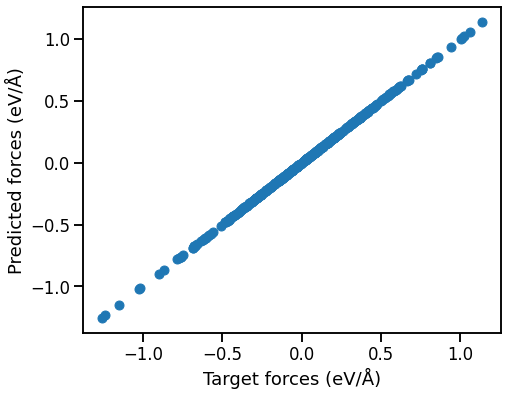

In [12]:
print('test  error: {:10.6f} (eV/Å)'.format(opt.rmse_test))
print('train error: {:10.6f} (eV/Å)'.format(opt.rmse_train))

sd = opt.scatter_data_test
fig = plt.figure(figsize=(7.5, 6))
plt.plot(sd.target, sd.predicted, 'o')
plt.xlabel('Target forces (eV/Å)')
plt.ylabel('Predicted forces (eV/Å)');

### ForceConstantPotential
Finally we construct the ForceConstantPotential object. This puts together the information from the ClusterSpace with the parameters from the Optimizer.

In [13]:
from hiphive import ForceConstantPotential
fcp = ForceConstantPotential(cs, opt.parameters)
fcp.write('fcc-nickel.fcp')
print(fcp)

=============== ForceConstantPotential ===============
Spacegroup Fm-3m (225)
Cell:
Cell([[0.0, 1.76, 1.76], [1.76, 0.0, 1.76], [1.76, 1.76, 0.0]])
Basis:
[[0. 0. 0.]]
Numbers: [28]
Cutoff matrix:
[[ 5.  4.  4.]
 [nan  4.  4.]
 [nan nan  4.]]
Order 2, #orbits 5, #cluster 28, #parameters 12
Order 3, #orbits 4, #cluster 38, #parameters 19
Order 4, #orbits 11, #cluster 105, #parameters 88
Total number of orbits: 20
total number of clusters: 171
total number of parameters: 119


## Harmonic analysis

Although the constructed force constant potential is a fourth-order expansion we can still use the second order part for some basic analysis.

The force constant potential can be used to get force constants from any supercell compatible with the cutoff. Together with other tools and softwares thermal properties can be analyzed within the framework of force constants or molecular dynamics. We will start with the former and use our potential to get the dispersion relation and mean squared displacement for some temperatures in the harmonic approximation with the help of phonopy and its python API.

### Setting up ForceConstants and phonopy
First, in order to phonopy to work, we need to decide upon some parameters like `dim` and for the k-space interpolation.

In [14]:
# phonopy parameters
dim = 5  # dimension in phonopy calculation
Nq = 51  # number of q-points along each segment of the path through the BZ
mesh = [32, 32, 32]  # q-point mesh for MSD calculation
temperatures = [300, 600, 900, 1200]  # temperatures for evaluating MSD

Next we define a corresponding `PhonopyAtoms` object (`atoms_phonopy`) from the primitive structure `prim`, and initialize a `Phonopy` object (`phonopy`) that represents the chosen supercell size.

In [15]:
import numpy as np
from hiphive import ForceConstantPotential
from phonopy import Phonopy
from phonopy.structure.atoms import PhonopyAtoms

atoms_phonopy = PhonopyAtoms(symbols=prim.get_chemical_symbols(),
                             scaled_positions=prim.get_scaled_positions(),
                             cell=prim.cell)
phonopy = Phonopy(atoms_phonopy, supercell_matrix=dim*np.eye(3), primitive_matrix=None)

Now we retrieve the supercell (``supercell``) from the `phonopy` object, for which we want to set up the second-order force constant matrix. The latter is then generated using the `ForceConstantPotential.get_force_constants` method.

In [16]:
from ase import Atoms
supercell = phonopy.get_supercell()
supercell = Atoms(cell=supercell.cell, numbers=supercell.numbers, pbc=True,
                  scaled_positions=supercell.get_scaled_positions())
fcs = fcp.get_force_constants(supercell)
print(fcs)

=================== ForceConstants ===================
Orders: [2, 3, 4]
Atoms: Atoms(symbols='Ni125', pbc=True, cell=[[0.0, 8.8, 8.8], [8.8, 0.0, 8.8], [8.8, 8.8, 0.0]])

Cluster: (0, 0)
Atom('Ni', [0.0, 0.0, 0.0], index=0)
Atom('Ni', [0.0, 0.0, 0.0], index=0)
Force constant:
[[11.44021  0.       0.     ]
 [ 0.      11.44021 -0.     ]
 [ 0.      -0.      11.44021]]

Cluster: (0, 1)
Atom('Ni', [0.0, 0.0, 0.0], index=0)
Atom('Ni', [0.0, 1.7600000000000002, 1.7600000000000002], index=1)
Force constant:
[[ 0.05378 -0.       0.     ]
 [ 0.      -1.54054 -1.58878]
 [-0.      -1.58878 -1.54054]]

Cluster: (0, 2)
Atom('Ni', [0.0, 0.0, 0.0], index=0)
Atom('Ni', [0.0, 3.5200000000000005, 3.5200000000000005], index=2)
Force constant:
[[-0.00043  0.       0.     ]
 [-0.       0.00182  0.0026 ]
 [ 0.       0.0026   0.00182]]

...

Cluster: (123, 123, 124, 124)
Atom('Ni', [14.080000000000002, 12.320000000000002, 12.320000000000002], index=123)
Atom('Ni', [14.080000000000002, 12.320000000000002, 12.

The `ForceConstants` objects `fcs` can also be printed but if we want to view just a specific force constant we can use the `print_force_constant` method. Here, a cluster is referred to by the indices of its sites in the supercell.

In [17]:
# access specific parts of the force constant matrix
fcs.print_force_constant((0, 1))
fcs.print_force_constant((10, 12))

# fcs also supports indexing via
fc_05 = fcs[0, 5]
print(fc_05)

Cluster: (0, 1)
Atom('Ni', [0.0, 0.0, 0.0], index=0)
Atom('Ni', [0.0, 1.7600000000000002, 1.7600000000000002], index=1)
Force constant:
[[ 0.05378 -0.       0.     ]
 [ 0.      -1.54054 -1.58878]
 [-0.      -1.58878 -1.54054]]
Cluster: (10, 12)
Atom('Ni', [3.5200000000000005, 0.0, 3.5200000000000005], index=10)
Atom('Ni', [3.5200000000000005, 3.5200000000000005, 7.040000000000001], index=12)
Force constant:
[[-0.00043  0.       0.     ]
 [-0.       0.00182  0.0026 ]
 [ 0.       0.0026   0.00182]]
[[-1.54053610e+00 -4.08461913e-17 -1.58877911e+00]
 [ 3.12695951e-17  5.37829470e-02 -3.63178943e-17]
 [-1.58877911e+00  3.57978921e-17 -1.54053610e+00]]


### Mean-square displacements
Now we can conduct an analysis of the mean-square displacement (and
potentially other thermal properties) at several temperatures.

In [18]:
# get second order force constants
fc2 = fcs.get_fc_array(order=2)
print(fc2.shape)

# compute MSD
phonopy.set_force_constants(fc2)
phonopy.set_mesh(mesh, is_eigenvectors=True, is_mesh_symmetry=False)
phonopy.set_thermal_displacements(temperatures=temperatures)
_, msds = phonopy.get_thermal_displacements()
msds = np.sum(msds, axis=1)  # sum up the MSD over x,y,z
for temperature, msd in zip(temperatures, msds):
    print('T = {:4d} K    MSD = {:.5f} Å**2'.format(temperature, msd))

(125, 125, 3, 3)
T =  300 K    MSD = 0.01316 Å**2
T =  600 K    MSD = 0.02530 Å**2
T =  900 K    MSD = 0.03767 Å**2
T = 1200 K    MSD = 0.05010 Å**2


This is the mean squared displacements and can be compared to the MD results later in the tutorial.

### Phonon dispersion
It is equally straightforward to extract the phonon dispersion. After one has defined a path through the Brillouin zone (BZ) this only requires two lines of code thanks to [phonopy](https://atztogo.github.io/phonopy/).

In [19]:
def get_band(q_start, q_stop, N):
    """ Return path between q_start and q_stop """
    return np.array([q_start + (q_stop-q_start)*i/(N-1) for i in range(N)])


# setup band path
G2X = get_band(np.array([0, 0, 0]), np.array([0.5, 0.5, 0]), Nq)
X2K2G = get_band(np.array([0.5, 0.5, 1.0]), np.array([0, 0, 0]), Nq)
G2L = get_band(np.array([0, 0, 0]), np.array([0.5, 0.5, 0.5]), Nq)
bands = [G2X, X2K2G, G2L]

# get phonon dispersion
phonopy.set_band_structure(bands)
qvecs, qnorms, freqs, _ = phonopy.get_band_structure()

Finally, we can plot the phonon dispersion.

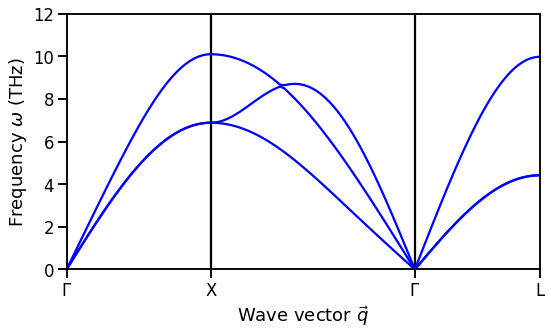

In [20]:
fig = plt.figure(figsize=(8, 5))

kpts = [0.0, qnorms[0][-1], qnorms[1][-1], qnorms[2][-1]]
kpts_labels = ['$\\Gamma$', 'X', '$\\Gamma$', 'L']

plt.axvline(x=kpts[1], color='k')
plt.axvline(x=kpts[2], color='k')

for q, freq, in zip(qnorms, freqs):
    plt.plot(q, freq, color='b')

plt.xlabel('Wave vector $\\vec{q}$')
plt.ylabel('Frequency $\\omega$ (THz)')
plt.xticks(kpts, kpts_labels)
plt.xlim([0.0, qnorms[-1][-1]])
plt.ylim([0.0, 12.0])

plt.tight_layout()

This yields the above dispersion, which is virtually indistinguishable from
the dispersion one obtains when using the EMT calculator directly.